In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2


from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm
import pandas as pd

In [ ]:
from skimage import io, filters, feature
from skimage.color import rgb2gray
from skimage.filters import frangi,unsharp_mask

In [ ]:
def show_img(path, resize = None):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #gray scale
  img = cv2.equalizeHist(img) #histogram equalization
  sharpen = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) #sharpening image
  img = cv2.filter2D(img,-1,sharpen)
  if resize != None:
    img = cv2.resize(img, resize, interpolation = cv2.INTER_AREA) 
  return img

def over_sampling(class0, class1, class2, class3, class4, class5, class6):
  
  len0 = len(os.listdir(class0))
  len1 = len(os.listdir(class1))
  len2 = len(os.listdir(class2))
  len3 = len(os.listdir(class3))
  len4 = len(os.listdir(class4))
  len5 = len(os.listdir(class5))
  len6 = len(os.listdir(class6)) 

  res_df = pd.DataFrame()

  df_class0 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class0):
      img_path = os.path.join(class0, i)
      df_class0["images"].append(show_img(img_path, (224, 224)))
      df_class0["label"].append(0)
  df_class0 = pd.DataFrame(df_class0)

  df_class1 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class1):
      img_path = os.path.join(class1, i)
      df_class1["images"].append(show_img(img_path, (224, 224)))
      df_class1["label"].append(1)
  df_class1 = pd.DataFrame(df_class1)
  df_class1 = df_class1.sample(400, replace = True, random_state = 42)

  df_class2 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class2):
      img_path = os.path.join(class2, i)
      df_class2["images"].append(show_img(img_path, (224, 224)))
      df_class2["label"].append(2)
  df_class2 = pd.DataFrame(df_class2)

  df_class3 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class3):
      img_path = os.path.join(class3, i)
      df_class3["images"].append(show_img(img_path, (224, 224)))
      df_class3["label"].append(3)
  df_class3 = pd.DataFrame(df_class3)

  df_class4 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class4):
      img_path = os.path.join(class4, i)
      df_class4["images"].append(show_img(img_path, (224, 224)))
      df_class4["label"].append(4)
  df_class4 = pd.DataFrame(df_class4)


  df_class5 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class5):
      img_path = os.path.join(class5, i)
      df_class5["images"].append(show_img(img_path, (224, 224)))
      df_class5["label"].append(5)
  df_class5 = pd.DataFrame(df_class5)

  df_class6 = {
        "images": [],
        "label": []
    }
  for i in os.listdir(class6):
      img_path = os.path.join(class6, i)
      df_class6["images"].append(show_img(img_path, (224, 224)))
      df_class6["label"].append(6)
  df_class6 = pd.DataFrame(df_class6)
  df_class6 = df_class6.sample(400, replace = True, random_state = 42)

  print("EA: ", df_class0.count())
  print("EH_Complex: ", df_class1.count())
  print("EH_Simple: ", df_class2.count())
  print("EP: ", df_class3.count())
  print("NE_Follicular: ", df_class4.count())
  print("NE_Luteal: ", df_class5.count())
  print("NE_Menstrual: ", df_class6.count())
  
  res_df = pd.concat([df_class0, df_class1, df_class2, df_class3, df_class4, df_class5, df_class6], axis = 0)
  return (np.array(list(res_df["images"])), np.array(res_df["label"]))

over_x, over_y = over_sampling("/content/drive/MyDrive/Tarp/Dataset/EA", "/content/drive/MyDrive/Tarp/Dataset/EH_Complex", "/content/drive/MyDrive/Tarp/Dataset/EH_Simple",
                               "/content/drive/MyDrive/Tarp/Dataset/EP", "/content/drive/MyDrive/Tarp/Dataset/NE_Follicular", "/content/drive/MyDrive/Tarp/Dataset/NE_Luteal", 
                               "/content/drive/MyDrive/Tarp/Dataset/NE_Menstrual")

images    201
label     201
dtype: int64
images    495
label     495
dtype: int64
images    495
label     495
dtype: int64


In [ ]:
over_x.shape

(990, 300, 300)

In [ ]:
equalized_imgs_x = np.repeat(over_x[..., np.newaxis], 3, -1)
equalized_imgs_x.shape

(990, 300, 300, 3)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    equalized_imgs_x, over_y, test_size=0.33, random_state=42, stratify = over_y)

In [ ]:
x_train.shape

(663, 300, 300, 3)

In [ ]:
x_test.shape

(327, 300, 300, 3)

In [ ]:
y_train.shape, sum(y_train == 0), sum(y_train == 1)

((663,), 331, 332)

In [ ]:
y_test.shape, sum(y_test == 0), sum(y_test == 1)

((327,), 164, 163)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomContrast
import tensorflow as tf

In [ ]:
data_augmentation = Sequential([
  RandomFlip('horizontal_and_vertical'),
  RandomRotation(10),
  RandomTranslation(width_factor=0.2, height_factor=0.2),
  RandomContrast(factor=0.2)
])

preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
def model_result(funcs, aug = False):

  res_df = pd.DataFrame()
  res_df["Convolution Model"] = pd.Series([])
  res_df["Accuracy"] = pd.Series([])
  res_df["True Negatives"] = pd.Series([])
  res_df["False Negatives"] = pd.Series([])
  res_df["True Positives"] = pd.Series([])
  res_df["False Positives"] = pd.Series([])

  for i in funcs:
    base_model = i
    #Load model without classifier/fully connected layers
    inp_model = base_model(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
    )
    #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in inp_model.layers:
      layer.trainable = False
    
    if aug == True:
      inputs = Input(shape=(224 ,224, 3))
      x = data_augmentation(inputs)
      # x = preprocess_input(inputs)
      outputs = inp_model(x)
      inp_model = tf.keras.Model(inputs, outputs)
    # inp_model.summary()  #Trainable parameters will be 0

    #Now, let us use features from convolutional network for RF
    feature_extractor = inp_model.predict(x_train)

    features = feature_extractor.reshape(feature_extractor.shape[0], -1)

    X_for_RF = features #This is our X input to RF

    #RANDOM FOREST
    from sklearn.ensemble import RandomForestClassifier
    RF_model = RandomForestClassifier(n_estimators = 100, random_state = 42)

    # Train the model on training data
    RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

    #Send test data through same feature extractor process
    X_test_feature = inp_model.predict(x_test)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

    #Now predict using the trained RF model. 
    prediction_RF = RF_model.predict(X_test_features)

    #Print overall accuracy
    from sklearn import metrics
    acc = metrics.accuracy_score(y_test, prediction_RF)
    print ("Accuracy = ", acc)

    #Confusion Matrix - verify accuracy of each class
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, prediction_RF)
    #print(cm)
    # sns.heatmap(cm, annot=True)
    res_df.loc[len(res_df)] = [str(i), acc, cm[0][0], cm[1][0], cm[1][1], cm[0][1]]
    print(res_df.loc[len(res_df) - 1])
    #Check results on a few select images
    n=np.random.randint(0, x_test.shape[0])
    img = x_test[n]
    plt.imshow(img)
    input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
    input_img_feature= inp_model.predict(input_img)
    input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
    prediction_RF = RF_model.predict(input_img_features)[0]
    print("The prediction for this image is: ", prediction_RF)
    print("The actual label for this image is: ", y_test[n])
  
  return res_df

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetMobile, NASNetLarge
from tensorflow.keras.applications.resnet import ResNet101, ResNet152
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
cnn_models = [ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2, Xception, VGG16, VGG19, InceptionV3, InceptionResNetV2, DenseNet201, DenseNet121, DenseNet169]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/pyt

Accuracy =  0.9296636085626911
Convolution Model    <function ResNet50 at 0x7f45543384d0>
Accuracy                                          0.929664
True Negatives                                       152.0
False Negatives                                       11.0
True Positives                                       152.0
False Positives                                       12.0
Name: 0, dtype: object
The prediction for this image is:  0
The actual label for this image is:  0
Accuracy =  0.8960244648318043
Convolution Model    <function ResNet101 at 0x7f4554338560>
Accuracy                                           0.896024
True Negatives                                        145.0
False Negatives                                        15.0
True Positives                                        148.0
False Positives                                        19.0
Name: 1, dtype: object
The prediction for this image is:  0
The actual label for this image is:  0
Accuracy =  0.886850152905

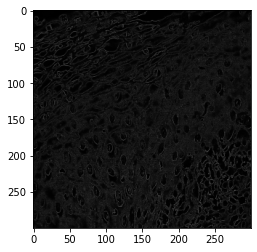

In [ ]:
cnn_models_400x = model_result(cnn_models)

In [ ]:
print(cnn_models_400x)

                                 Convolution Model  Accuracy  True Negatives  \
0            <function ResNet50 at 0x7f45543384d0>  0.929664           152.0   
1           <function ResNet101 at 0x7f4554338560>  0.896024           145.0   
2           <function ResNet152 at 0x7f45543385f0>  0.886850           144.0   
3          <function ResNet50V2 at 0x7f4554338b00>  0.880734           146.0   
4         <function ResNet101V2 at 0x7f4554338a70>  0.865443           140.0   
5         <function ResNet152V2 at 0x7f455433e0e0>  0.856269           142.0   
6            <function Xception at 0x7f455433ee60>  0.862385           141.0   
7               <function VGG16 at 0x7f455433e440>  0.899083           140.0   
8               <function VGG19 at 0x7f455433e950>  0.902141           149.0   
9         <function InceptionV3 at 0x7f4554312b90>  0.877676           140.0   
10  <function InceptionResNetV2 at 0x7f4554388f80>  0.853211           142.0   
11        <function DenseNet201 at 0x7f4